# Task 2: Clustering

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading the Customer Profile model

In [58]:
customer_profile = pd.read_csv('../dataset/customer_profile_model.csv', sep='\t', index_col=0)
customer_profile

,I,Iu,Imax,E,Monetary,Recency,T,Frequency
CustomerID,,,,,,,,
12747.0,6.674561,3.367296,4.941642,1.465815,5.762366,2.079442,5.831882,5.467828
12748.0,9.485925,7.273786,7.108244,1.899053,5.814429,4.553877,5.828946,5.230059
12749.0,7.110696,4.787492,6.439350,1.557404,5.746523,1.098612,5.817111,6.259486
12820.0,6.513230,3.988984,5.497168,1.410074,5.642262,1.098612,5.789960,5.526064
12822.0,6.122493,3.610918,5.913503,1.413603,2.839078,0.000000,4.477337,5.050369
...,...,...,...,...,...,...,...,...
18272.0,7.367709,4.477337,5.863631,1.557192,5.407620,1.609438,5.420535,6.203935
18273.0,3.688879,0.000000,2.995732,-2.302585,4.673763,0.000000,5.552960,3.933784
18282.0,3.931826,2.079442,3.258097,1.047319,4.443827,0.000000,5.707110,4.109069


In [59]:
customer_profile = customer_profile.to_numpy()

In [60]:
from sklearn.metrics import silhouette_score

def silhouette_scorer(pipeline, X):
    pipeline.fit(X)
    cluster_labels = pipeline['clustering'].labels_
    n_labels = len(set(cluster_labels))
    n_samples = X.shape[0]
    if n_labels == 1 or n_labels == n_samples:
        return -1
    else:
        return silhouette_score(X, cluster_labels)

In [61]:
def highlight_equal(s, value, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] == value
    return ['background-color: lightyellow' if is_max.any() else '' for v in is_max]

## K-means

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [63]:
pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                           ('pca', PCA()), # a common practice before doing clustering: PCA which calculates the dimensions which best maximize variance; 
                           # it does dimensionality reduction while keeping the most important features, i.e. combinations of features best describe customers.
                           ('clustering', KMeans(init='k-means++'))])

n_features = customer_profile.shape[1]

# parameters of pipelines can be set using ‘__’ separated parameter names
tuned_parameters = {
    'pca__n_components': range(2, n_features + 1),
    'clustering__n_clusters': range(2, 10)}

search = GridSearchCV(estimator=pipeline, 
                      param_grid=tuned_parameters, 
                      scoring=silhouette_scorer, 
                      cv=[(slice(None), slice(None))],  # https://stackoverflow.com/a/44682305/5555994
                      n_jobs=-1,  # use all processors
                      refit=True, 
                      verbose=True).fit(customer_profile)

Fitting 1 folds for each of 56 candidates, totalling 56 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:    4.9s finished


In [64]:
kmeans_results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score')
kmeans_results.head(10).style.apply(highlight_equal, value=1, column=['rank_test_score'], axis=1).hide_index()

params,mean_test_score,rank_test_score
"{'clustering__n_clusters': 2, 'pca__n_components': 5}",0.339084,1
"{'clustering__n_clusters': 2, 'pca__n_components': 6}",0.337813,2
"{'clustering__n_clusters': 2, 'pca__n_components': 8}",0.337126,3
"{'clustering__n_clusters': 2, 'pca__n_components': 7}",0.337019,4
"{'clustering__n_clusters': 2, 'pca__n_components': 3}",0.336918,5
"{'clustering__n_clusters': 2, 'pca__n_components': 2}",0.335895,6
"{'clustering__n_clusters': 2, 'pca__n_components': 4}",0.333622,7
"{'clustering__n_clusters': 4, 'pca__n_components': 7}",0.263776,8
"{'clustering__n_clusters': 4, 'pca__n_components': 8}",0.263776,8
"{'clustering__n_clusters': 4, 'pca__n_components': 4}",0.263695,10


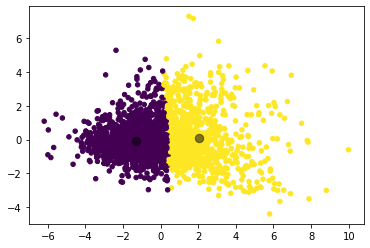

In [65]:
# create a scatter plot
scaled_customer_profile = search.best_estimator_['scaler'].transform(customer_profile)
pca_customer_profile = search.best_estimator_['pca'].transform(scaled_customer_profile)
clusters_customers = search.predict(customer_profile) # scaling and pca are done in the pipeline
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20)
# select cluster centers
centroids = search.best_estimator_['clustering'].cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);

What's the number of customers in each cluster?

In [66]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNo']).T

,0,1
CustomersNo,1396,885


## DBSCAN

In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [68]:
pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                           ('pca', PCA()), # a common practice before doing clustering: PCA which calculates the dimensions which best maximize variance; 
                           # it does dimensionality reduction while keeping the most important features, i.e. combinations of features best describe customers.
                           ('clustering', DBSCAN())])

n_features = customer_profile.shape[1]

# parameters of pipelines can be set using ‘__’ separated parameter names
tuned_parameters = {
    'pca__n_components': range(2, n_features + 1),
    'clustering__eps': (0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4),
    'clustering__metric': ('euclidean', 'manhattan', 'cosine'),
    'clustering__min_samples': (5, 10)}

search = GridSearchCV(estimator=pipeline, 
                      param_grid=tuned_parameters, 
                      scoring=silhouette_scorer, 
                      cv=[(slice(None), slice(None))],  # https://stackoverflow.com/a/44682305/5555994
                      n_jobs=-1,  # use all processors
                      refit=True, 
                      verbose=True).fit(customer_profile)

Fitting 1 folds for each of 294 candidates, totalling 294 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 294 out of 294 | elapsed:    7.3s finished


In [69]:
dbscan_results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score')
dbscan_results.head(10).style.apply(highlight_equal, value=1, column=['rank_test_score'], axis=1).hide_index()

params,mean_test_score,rank_test_score
"{'clustering__eps': 0.4, 'clustering__metric': 'euclidean', 'clustering__min_samples': 10, 'pca__n_components': 2}",0.386179,1
"{'clustering__eps': 0.35, 'clustering__metric': 'euclidean', 'clustering__min_samples': 10, 'pca__n_components': 2}",0.363638,2
"{'clustering__eps': 0.3, 'clustering__metric': 'euclidean', 'clustering__min_samples': 10, 'pca__n_components': 2}",0.191375,3
"{'clustering__eps': 0.4, 'clustering__metric': 'euclidean', 'clustering__min_samples': 5, 'pca__n_components': 2}",0.091342,4
"{'clustering__eps': 0.35, 'clustering__metric': 'manhattan', 'clustering__min_samples': 5, 'pca__n_components': 2}",0.089925,5
"{'clustering__eps': 0.4, 'clustering__metric': 'manhattan', 'clustering__min_samples': 10, 'pca__n_components': 2}",0.085833,6
"{'clustering__eps': 0.35, 'clustering__metric': 'manhattan', 'clustering__min_samples': 10, 'pca__n_components': 2}",-0.000472,7
"{'clustering__eps': 0.4, 'clustering__metric': 'euclidean', 'clustering__min_samples': 5, 'pca__n_components': 3}",-0.044542,8
"{'clustering__eps': 0.3, 'clustering__metric': 'manhattan', 'clustering__min_samples': 10, 'pca__n_components': 2}",-0.060467,9
"{'clustering__eps': 0.25, 'clustering__metric': 'euclidean', 'clustering__min_samples': 10, 'pca__n_components': 2}",-0.071277,10


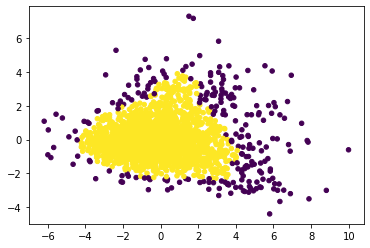

In [70]:
# create a scatter plot
scaled_customer_profile = search.best_estimator_['scaler'].transform(customer_profile)
pca_customer_profile = search.best_estimator_['pca'].transform(scaled_customer_profile)
clusters_customers = search.best_estimator_['clustering'].fit_predict(pca_customer_profile)
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20);

What's the number of customers in each cluster?

In [71]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNo']).T

,0,-1
CustomersNo,2045,236


## Agglomerative Clustering

In [72]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion.

- *ward* minimizes the variance of the clusters being merged
- *average* uses the average of the distances of each observation of the two sets
- *complete* or maximum linkage uses the maximum distances between all observations of the two sets
- *single* uses the minimum of the distances between all observations of the two sets

### Ward Linkage

In [73]:
pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                           # skipping PCA since agglomerative clustering uses the Feature Agglomeration to group together features 
                           # that look very similar, thus decreasing the number of features. It is a dimensionality reduction tool.
                           ('clustering', AgglomerativeClustering(linkage='ward'))])

n_features = customer_profile.shape[1]

# parameters of pipelines can be set using ‘__’ separated parameter names
tuned_parameters = {
    'clustering__n_clusters' : range(2, 10),
    'clustering__affinity': ('euclidean', 'manhattan', 'cosine')}

search = GridSearchCV(estimator=pipeline, 
                      param_grid=tuned_parameters, 
                      scoring=silhouette_scorer, 
                      cv=[(slice(None), slice(None))],  # https://stackoverflow.com/a/44682305/5555994
                      n_jobs=-1,  # use all processors
                      refit=True, 
                      verbose=True).fit(customer_profile)

Fitting 1 folds for each of 24 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.9s finished


In [74]:
agglomerative_results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score')
agglomerative_results.head(10).style.apply(highlight_equal, value=1, column=['rank_test_score'], axis=1).hide_index()

params,mean_test_score,rank_test_score
"{'clustering__affinity': 'euclidean', 'clustering__n_clusters': 2}",0.310335,1
"{'clustering__affinity': 'euclidean', 'clustering__n_clusters': 3}",0.297844,2
"{'clustering__affinity': 'euclidean', 'clustering__n_clusters': 4}",0.269474,3
"{'clustering__affinity': 'euclidean', 'clustering__n_clusters': 5}",0.174692,4
"{'clustering__affinity': 'euclidean', 'clustering__n_clusters': 7}",0.172166,5
"{'clustering__affinity': 'euclidean', 'clustering__n_clusters': 6}",0.168517,6
"{'clustering__affinity': 'euclidean', 'clustering__n_clusters': 9}",0.146249,7
"{'clustering__affinity': 'euclidean', 'clustering__n_clusters': 8}",0.145412,8
"{'clustering__affinity': 'cosine', 'clustering__n_clusters': 7}",nan,9
"{'clustering__affinity': 'cosine', 'clustering__n_clusters': 6}",nan,10


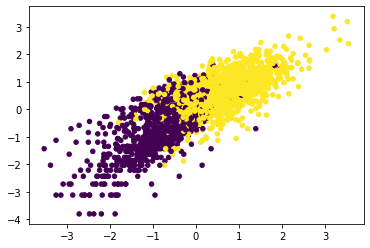

In [75]:
# create a scatter plot
scaled_customer_profile = search.best_estimator_['scaler'].transform(customer_profile)
clusters_customers = search.best_estimator_['clustering'].fit_predict(scaled_customer_profile)
plt.scatter(scaled_customer_profile[:, 0], scaled_customer_profile[:, 1], c=clusters_customers, s=20);

What's the number of customers in each cluster?

In [76]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNo']).T

,1,0
CustomersNo,1342,939


### Complete Linkage

In [77]:
pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                           # skipping PCA since agglomerative clustering uses the Feature Agglomeration to group together features 
                           # that look very similar, thus decreasing the number of features. It is a dimensionality reduction tool.
                           ('clustering', AgglomerativeClustering(linkage='complete'))])

n_features = customer_profile.shape[1]

# parameters of pipelines can be set using ‘__’ separated parameter names
tuned_parameters = {
    'clustering__n_clusters' : range(2, 10),
    'clustering__affinity': ('euclidean', 'manhattan', 'cosine')}

search = GridSearchCV(estimator=pipeline, 
                      param_grid=tuned_parameters, 
                      scoring=silhouette_scorer, 
                      cv=[(slice(None), slice(None))],  # https://stackoverflow.com/a/44682305/5555994
                      n_jobs=-1,  # use all processors
                      refit=True, 
                      verbose=True).fit(customer_profile)

Fitting 1 folds for each of 24 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.4s finished


In [78]:
agglomerative_results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score')
agglomerative_results.head(10).style.apply(highlight_equal, value=1, column=['rank_test_score'], axis=1).hide_index()

params,mean_test_score,rank_test_score
"{'clustering__affinity': 'euclidean', 'clustering__n_clusters': 2}",0.521929,1
"{'clustering__affinity': 'cosine', 'clustering__n_clusters': 2}",0.316967,2
"{'clustering__affinity': 'euclidean', 'clustering__n_clusters': 4}",0.270796,3
"{'clustering__affinity': 'euclidean', 'clustering__n_clusters': 5}",0.267267,4
"{'clustering__affinity': 'manhattan', 'clustering__n_clusters': 3}",0.266818,5
"{'clustering__affinity': 'manhattan', 'clustering__n_clusters': 4}",0.262950,6
"{'clustering__affinity': 'manhattan', 'clustering__n_clusters': 2}",0.262778,7
"{'clustering__affinity': 'euclidean', 'clustering__n_clusters': 6}",0.257808,8
"{'clustering__affinity': 'manhattan', 'clustering__n_clusters': 5}",0.256803,9
"{'clustering__affinity': 'euclidean', 'clustering__n_clusters': 3}",0.246599,10


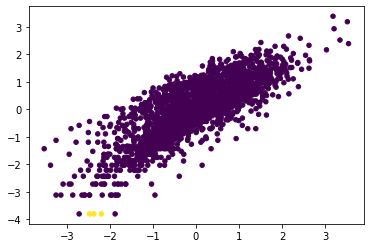

In [79]:
# create a scatter plot
scaled_customer_profile = search.best_estimator_['scaler'].transform(customer_profile)
clusters_customers = search.best_estimator_['clustering'].fit_predict(scaled_customer_profile)
plt.scatter(scaled_customer_profile[:, 0], scaled_customer_profile[:, 1], c=clusters_customers, s=20);

What's the number of customers in each cluster?

In [80]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNo']).T

,0,1
CustomersNo,2276,5


### Average Linkage

In [81]:
pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                           # skipping PCA since agglomerative clustering uses the Feature Agglomeration to group together features 
                           # that look very similar, thus decreasing the number of features. It is a dimensionality reduction tool.
                           ('clustering', AgglomerativeClustering(linkage='average'))])

n_features = customer_profile.shape[1]

# parameters of pipelines can be set using ‘__’ separated parameter names
tuned_parameters = {
    'clustering__n_clusters' : range(2, 10),
    'clustering__affinity': ('euclidean', 'manhattan', 'cosine')}

search = GridSearchCV(estimator=pipeline, 
                      param_grid=tuned_parameters, 
                      scoring=silhouette_scorer, 
                      cv=[(slice(None), slice(None))],  # https://stackoverflow.com/a/44682305/5555994
                      n_jobs=-1,  # use all processors
                      refit=True, 
                      verbose=True).fit(customer_profile)

Fitting 1 folds for each of 24 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    2.6s finished


In [82]:
agglomerative_results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score')
agglomerative_results.head(10).style.apply(highlight_equal, value=1, column=['rank_test_score'], axis=1).hide_index()

params,mean_test_score,rank_test_score
"{'clustering__affinity': 'euclidean', 'clustering__n_clusters': 2}",0.521929,1
"{'clustering__affinity': 'manhattan', 'clustering__n_clusters': 2}",0.458164,2
"{'clustering__affinity': 'manhattan', 'clustering__n_clusters': 3}",0.445733,3
"{'clustering__affinity': 'manhattan', 'clustering__n_clusters': 4}",0.428713,4
"{'clustering__affinity': 'euclidean', 'clustering__n_clusters': 3}",0.422432,5
"{'clustering__affinity': 'euclidean', 'clustering__n_clusters': 4}",0.342600,6
"{'clustering__affinity': 'euclidean', 'clustering__n_clusters': 5}",0.340761,7
"{'clustering__affinity': 'manhattan', 'clustering__n_clusters': 5}",0.335329,8
"{'clustering__affinity': 'manhattan', 'clustering__n_clusters': 6}",0.329052,9
"{'clustering__affinity': 'euclidean', 'clustering__n_clusters': 6}",0.315041,10


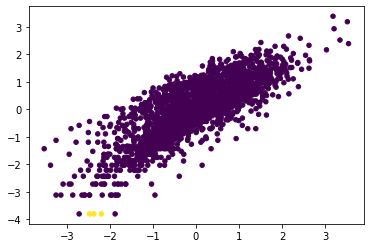

In [83]:
# create a scatter plot
scaled_customer_profile = search.best_estimator_['scaler'].transform(customer_profile)
clusters_customers = search.best_estimator_['clustering'].fit_predict(scaled_customer_profile)
plt.scatter(scaled_customer_profile[:, 0], scaled_customer_profile[:, 1], c=clusters_customers, s=20);

What's the number of customers in each cluster?

In [84]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNo']).T

,0,1
CustomersNo,2276,5


### Single Linkage

In [85]:
pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                           # skipping PCA since agglomerative clustering uses the Feature Agglomeration to group together features 
                           # that look very similar, thus decreasing the number of features. It is a dimensionality reduction tool.
                           ('clustering', AgglomerativeClustering(linkage='single'))])

n_features = customer_profile.shape[1]

# parameters of pipelines can be set using ‘__’ separated parameter names
tuned_parameters = {
    'clustering__n_clusters' : range(2, 10),
    'clustering__affinity': ('euclidean', 'manhattan', 'cosine')}

search = GridSearchCV(estimator=pipeline, 
                      param_grid=tuned_parameters, 
                      scoring=silhouette_scorer, 
                      cv=[(slice(None), slice(None))],  # https://stackoverflow.com/a/44682305/5555994
                      n_jobs=-1,  # use all processors
                      refit=True, 
                      verbose=True).fit(customer_profile)

Fitting 1 folds for each of 24 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    1.2s finished


In [86]:
agglomerative_results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score')
agglomerative_results.head(10).style.apply(highlight_equal, value=1, column=['rank_test_score'], axis=1).hide_index()

params,mean_test_score,rank_test_score
"{'clustering__affinity': 'euclidean', 'clustering__n_clusters': 2}",0.521929,1
"{'clustering__affinity': 'manhattan', 'clustering__n_clusters': 2}",0.521929,1
"{'clustering__affinity': 'manhattan', 'clustering__n_clusters': 3}",0.490630,3
"{'clustering__affinity': 'euclidean', 'clustering__n_clusters': 3}",0.489306,4
"{'clustering__affinity': 'manhattan', 'clustering__n_clusters': 4}",0.487810,5
"{'clustering__affinity': 'manhattan', 'clustering__n_clusters': 5}",0.487353,6
"{'clustering__affinity': 'euclidean', 'clustering__n_clusters': 4}",0.466385,7
"{'clustering__affinity': 'euclidean', 'clustering__n_clusters': 5}",0.465995,8
"{'clustering__affinity': 'manhattan', 'clustering__n_clusters': 6}",0.465993,9
"{'clustering__affinity': 'manhattan', 'clustering__n_clusters': 8}",0.436374,10


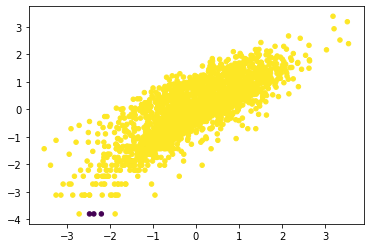

In [87]:
# create a scatter plot
scaled_customer_profile = search.best_estimator_['scaler'].transform(customer_profile)
clusters_customers = search.best_estimator_['clustering'].fit_predict(scaled_customer_profile)
plt.scatter(scaled_customer_profile[:, 0], scaled_customer_profile[:, 1], c=clusters_customers, s=20);

What's the number of customers in each cluster?

In [56]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNo']).T

,0,1
CustomersNo,2280,1
